# Transfer learning and fine-tuning base EfficientNet_B5 model

In [1]:
# !pip install tf-nightly

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [4]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [5]:
# ?image_dataset_from_directory

In [6]:
validation_dir
!ls /root/.keras/datasets/cats_and_dogs_filtered/validation

cats  dogs


Show the first nine images and labels from the training set:

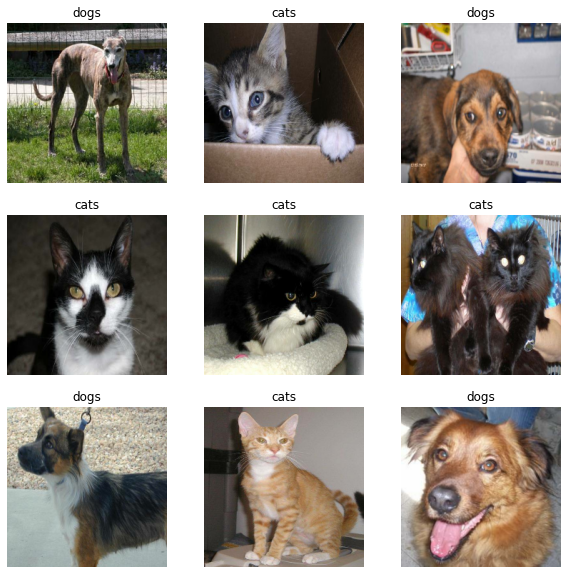

In [7]:
class_names = train_dataset.class_names

# 数据可视化
plt.figure(figsize=(10, 10))
# 从train_dataset里面拿一个batch size数量的图片和正解标签
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contains a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
# 验证集中一共有32个批次的batch数据（一个batch里面有32张图片），32个批次分成26和6，2个部分（验证和测试）
test_dataset = validation_dataset.take(val_batches//5)
validation_dataset = validation_dataset.skip(val_batches//5)

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
len(train_dataset),len(validation_dataset),len(test_dataset)

(63, 26, 6)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [12]:
data_augmentation=tf.keras.Sequential([
#     水平 垂直 翻转
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
#     旋转
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
#     缩放
    tf.keras.layers.experimental.preprocessing.RandomZoom(.5, .2),
#     图片上下shift20%，左右shift20%
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
#     独立的调整每个图片每个通道的对比度
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.1),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

In [13]:
image, label = next(iter(validation_dataset))
len(image)

32

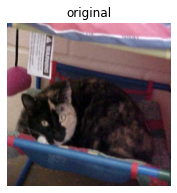

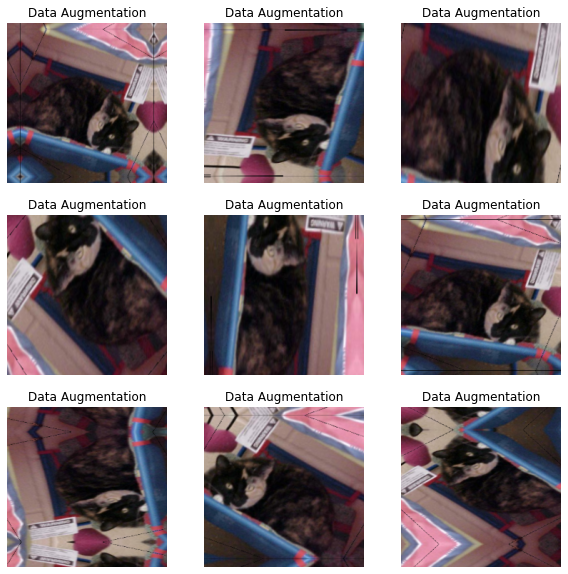

In [14]:
# 数据可视化
plt.figure(figsize=(3, 3))
first_image = image[0]
plt.subplot(1,1,1)
plt.imshow(first_image.numpy().astype("uint8"))
plt.title("original")
plt.axis('off')
plt.show()
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.title("Data Augmentation")
    plt.axis('off')

### Rescale pixel values

Note: Alternatively, you could rescale pixel values from `[0,255]` to `[-1, 1]` using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [15]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [16]:
# 通过preprocess_input处理，数据变成了-1到1之间的数值
a=rescale(images[0])
print(np.min(a),np.max(a))
# 原始图片是0到255之间的数值
np.min(images[0]),np.max(images[0])

-1.0 1.0


(0.0, 255.0)

## Create the base model from the pre-trained convnets

In [17]:
# Create the base model from the pre-trained model EfficientNetB5
# 设定维度为 (224, 224, 3)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB5(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',drop_connect_rate=0.4)

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [18]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [19]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [20]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [21]:
# 查看层数和层的名字
len(base_model.layers),base_model.layers[0].name

(576, 'input_1')

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [23]:
# 一共有1280个元素(特征)，通过这些元素来判断是猫还是狗
feature_batch_average[0]

<tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([ 0.25075573,  0.01391589,  0.39713457, ...,  0.01125406,
       -0.0931704 , -0.17171256], dtype=float32)>

Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [24]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [25]:
prediction_batch[0]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.16508737], dtype=float32)>

通过使用functional API链接 data augmentation, rescaling, base_model and feature extractor layers   
Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [26]:
# 使用functional API链接各个层
# 通过提高输入模型的图片解析度可以有效提高精度，并防止过拟合
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
# 数据标准化，使用的话精度不能收缩
# x = rescale(x)
# training=False表示推论模式，training=True表示训练模式
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [27]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb5 (Functional)  (None, 7, 7, 2048)        28513527  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [28]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb5 (Functional)  (None, 7, 7, 2048)        28513527  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [30]:
len(model.trainable_variables)

4

In [31]:
model.trainable_variables

[<tf.Variable 'batch_normalization/gamma:0' shape=(2048,) dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>,
 <tf.Variable 'batch_normalization/beta:0' shape=(2048,) dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense/kernel:0' shape=(2048, 1) dtype=float32, numpy=
 array([[ 0.04204046],
        [-0.01068836],
        [ 0.02886552],
        ...,
        [-0.04112717],
        [-0.03775422],
        [ 0.00633478]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [32]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 5s 188ms/step - loss: 0.6876 - accuracy: 0.5322


In [33]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.69
initial accuracy: 0.53


In [34]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 18s 283ms/step - loss: 0.5891 - accuracy: 0.7050 - val_loss: 0.5062 - val_accuracy: 0.7153
Epoch 2/10
63/63 [==============================] - 18s 279ms/step - loss: 0.3961 - accuracy: 0.8190 - val_loss: 0.3569 - val_accuracy: 0.8886
Epoch 3/10
63/63 [==============================] - 18s 282ms/step - loss: 0.3189 - accuracy: 0.8595 - val_loss: 0.2490 - val_accuracy: 0.9431
Epoch 4/10
63/63 [==============================] - 18s 284ms/step - loss: 0.2769 - accuracy: 0.8805 - val_loss: 0.1675 - val_accuracy: 0.9728
Epoch 5/10
63/63 [==============================] - 18s 287ms/step - loss: 0.2304 - accuracy: 0.9040 - val_loss: 0.1201 - val_accuracy: 0.9752
Epoch 6/10
63/63 [==============================] - 18s 290ms/step - loss: 0.2313 - accuracy: 0.9065 - val_loss: 0.0993 - val_accuracy: 0.9802
Epoch 7/10
63/63 [==============================] - 18s 292ms/step - loss: 0.2272 - accuracy: 0.9000 - val_loss: 0.0822 - val_accuracy: 0.9814

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

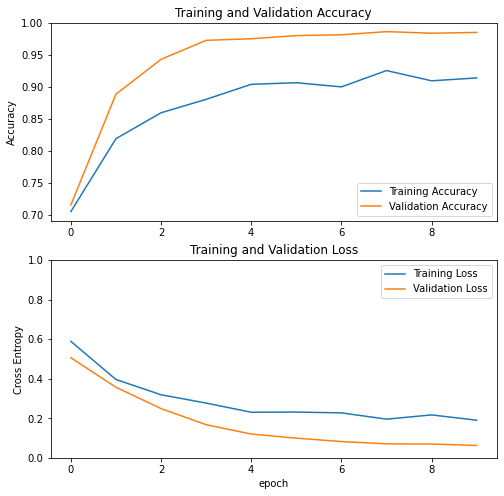

In [35]:
# 数据可视化
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [36]:
base_model.trainable = True

In [37]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 480

# 冻结了前面的100层，从101开始到末尾可以训练，这样提高了拟合的层数，应该可以获得更好的精度
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  576


### Compile the model

如果使用Adam作为激活函数最终测试结果是(推荐)      
6/6 [==============================] - 0s 26ms/step - loss: 0.0465 - accuracy: 0.9896   
Test accuracy : 0.9895833134651184   

如果使用RMSProp作为激活函数测试结果是   
6/6 [==============================] - 0s 26ms/step - loss: 0.0479 - accuracy: 0.9792   
Test accuracy : 0.979166   

In [38]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb5 (Functional)  (None, 7, 7, 2048)        28513527  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [40]:
# 可以训练的层数
len(model.trainable_variables)

88

### Continue training the model

In [41]:
# initial_epoch的目的是从第10次epoch开始，再执行10次epoch
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/15
63/63 [==============================] - 26s 418ms/step - loss: 0.1920 - accuracy: 0.9235 - val_loss: 0.0477 - val_accuracy: 0.9864
Epoch 11/15
63/63 [==============================] - 24s 376ms/step - loss: 0.1614 - accuracy: 0.9300 - val_loss: 0.0425 - val_accuracy: 0.9889
Epoch 12/15
63/63 [==============================] - 24s 377ms/step - loss: 0.1295 - accuracy: 0.9470 - val_loss: 0.0402 - val_accuracy: 0.9889
Epoch 13/15
63/63 [==============================] - 24s 378ms/step - loss: 0.1413 - accuracy: 0.9425 - val_loss: 0.0382 - val_accuracy: 0.9889
Epoch 14/15
63/63 [==============================] - 24s 378ms/step - loss: 0.1285 - accuracy: 0.9515 - val_loss: 0.0405 - val_accuracy: 0.9876
Epoch 15/15
63/63 [==============================] - 24s 379ms/step - loss: 0.1364 - accuracy: 0.9465 - val_loss: 0.0369 - val_accuracy: 0.9876


In [42]:
# 把上一次的acc加上这次history_fine.history['accuracy']的10次结果，一共是20次的结果保存
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

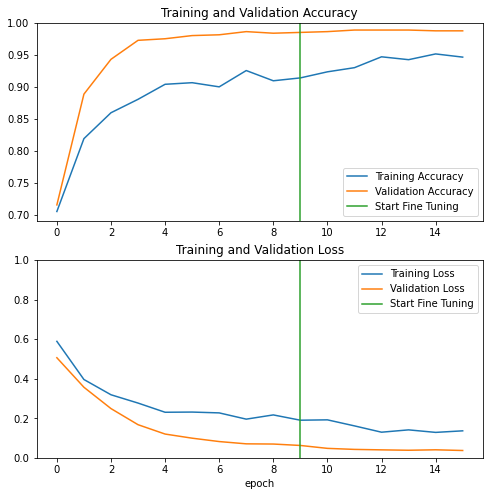

In [43]:
# 数据可视化
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

### 使用MobileNet模型进行迁移学习，最终的结果

In [44]:
# 使用MobileNet模型进行迁移学习，最终的结果
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 173ms/step - loss: 0.0333 - accuracy: 0.9948
Test accuracy : 0.9947916865348816


And now you are all set to use this model to predict if your pet is a cat or dog.

In [45]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
len(image_batch)

32

Predictions:
 [1 0 1 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0 1]
Labels:
 [1 0 1 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0 1]


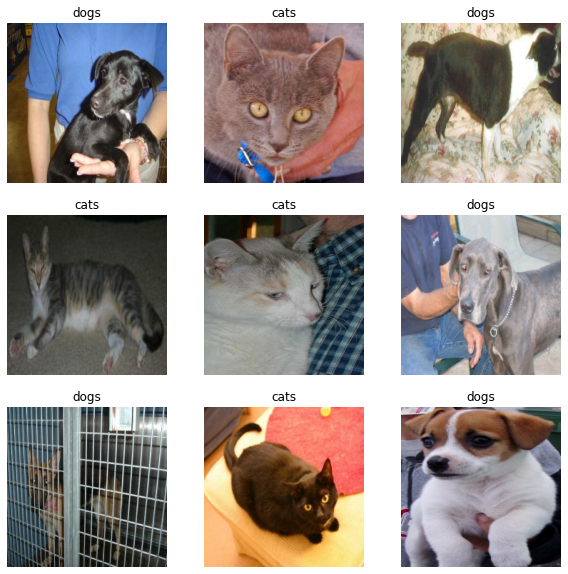

In [46]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

# 数据可视化
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")